In [16]:
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import csv
from keras.layers import Dense
from keras import models
from keras import layers
from keras import Sequential
from keras import optimizers
from keras import losses
from keras import metrics
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from IPython.display import Image


# <font color='EC2C04'> INTRODUCTION </font>

This project has the goal of **developing a model which could predict flight delays from McCarran International Airport of Las Vegas** (identified with 'LAS'). In this context, FAA ( Federal Administration Association ) has estimated the **annual costs of delays** (direct cost to airlines and passengers, lost demand, and indirect costs)  to have a value **around $26.6 billion**. Moreover, with the forecasts of airplane manufacturer Boeing which predicts Boeing’s new forecast predicts air passenger will nearly double by 2036, a serious attention needs to be paid in relationship with airlines performance in terms of punctuality and efficiency.

The analysis is an example of **binary classification problem**, which will be handled with deep learning methods. In particular, the goal is the one to obtain a model which could predict weather a flight is likely to be on time or to have a delay (which is recorded anytime the flight has a departure later than 15 minutes from the scheduled hour).

The airport of Las Vegas can return a valid output in terms of accuracy, due to the high amount of available observations (LAS as the eighth bigger airport of USA) , and since with the only available data at disposal it allows to exclude from the analysis all the information related to weather conditions ( the city of Las Vegas is built within the Mojave desert ) with high yearly average temperature and low yearly rainfall.

Data regards all the information gathered in the first semester of 2018, and they have been collected from the [Department of Transportation of United States](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time) website, which kindly made them available.


The first part of the analysis with deal with the process of **cleaning of data**, since they need to be modified for the specific purpose. Then, the phase of **pre-processing** of data will take place, and in the end a process of optimization and research for the **best deep learning model** will be set up. 



 ---

# <font color='EC2C04'> DATA MANAGEMENT </font>


## 1.Import the Data

In [21]:
df = pd.read_csv('lasvegasair.csv', delimiter=',')

# Drop the first of a series of column which will be dropped
df = df.drop(['Unnamed: 0'], axis = 1)

## 2. Data Wrangling

###  A. Dealing with Missing Values

In [0]:
missing = df.isnull().sum(axis = 0)
# print(missing)

**NOTE**:
One of the reason of the presence of missing values can be due to the fact that some flights have been cancelled.
I  observe if this hypotesis can be confirmed, by verifying the number of missing values as soon as the variable 'CANCELLED' has been removed

In [0]:
df = df.dropna(subset=['ARR_DELAY']) # I DROP EACH VALUE WHICH IS NA.
# CANCELLED COLUMN BECOME UNUSEFUL SINCE I DELETED EACH 1 VALUE SO I WILL DROP IT
df= df.drop(['CANCELLED'], axis=1)

# print(missing)

As previously guessed, the missing values do not exist anymore in this dataset.

### B. Setting the column 

In [0]:
# DROP THE UNUSEFUL VARIABLE

df = df.drop(['YEAR'], axis = 1)  # Since it is all 2018
df = df.drop(['ORIGIN_AIRPORT_ID'], axis = 1) # Since it is all Las Vegas
df = df.drop(['ORIGIN'], axis = 1) #  Since it is all Las Vegas
df = df.drop(['DEST_AIRPORT_ID'], axis = 1)

The following variable will be dropped from the dataset since the attempt is the one to build a model which predicts future delays, and their value cannot be known before the delay will concretely verify. Moreover, their trend is almost perfectly dependent to the one of the dependent variable, which can cause a phaenomenon of Multicollinearity.   
**MULTICOLLINEARITY**: Phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. 

In [0]:
df = df.drop(['ARR_DELAY'], axis= 1) 
df = df.drop(['DEP_DELAY'], axis= 1)
df = df.drop(['DEP_DEL15'], axis= 1)
df = df.drop(['DEP_TIME'], axis = 1) 
df = df.drop(['DEP_TIME_BLK'], axis= 1) 
df = df.drop(['ARR_TIME_BLK'], axis= 1) 



## 3. Pre-Processing

The dataset contains a great series of categorical variables, which need to be handled in order to be useful for the creation of the model.
In particular, each variable with the exception of 'AIR_TIME' and 'DISTANCE', and the case of 'TIME', can be considered as categorical.

However, initially these data will be treated with the **'OrdinalEncoding'** method, which consists in attribuiting to each category a number from 1 to n.
This choice simplifies the model, but it can cause several issues since observation are treated in the model like having a implicit order, while they are not. 
(E.g. if JFK airport is identified with number 10 and LAX airport with number 5, the model will consider JFK to be bigger than LAX ). This method will eventually be reviewed in order to obtain a better encoding, which on the other side will make the model more complicate.

The variable which need to be encoded in order to be useful for the model are the following:

1. **OP_UNIQUE_CARRIER**

2. **DEST**

### A. Time Processing

Time will be converted into number of minutes after midnight

In [0]:
# I NEED TO HAVE 4 DIGITS BEFORE TO CONVERT INTO TIME FORMAT
string = df['CRS_ARR_TIME'].apply(str)
ARR_TIME = []
for s in string:
    if len(s) == 3:
        s = '0'+ s
        ARR_TIME.append(s)
    elif len(s) == 1:
        s = '000'+ s 
        ARR_TIME.append(s)
    elif len(s) == 2:
        s = '00' + s
        ARR_TIME.append(s)
    else:
        s = s
        ARR_TIME.append(s)
df['ARR_TIME'] = ARR_TIME

string = df['CRS_DEP_TIME'].astype(str)
DEP_TIME = []
for s in string:
    if len(s) == 3:
        s = '0'+ s
        DEP_TIME.append(s)
    elif len(s) == 1:
        s = '000'+ s 
        DEP_TIME.append(s)
    elif len(s) == 2:
        s = '00' + s
        DEP_TIME.append(s)
    else:
        s = s
        DEP_TIME.append(s)
df['DEP_TIME'] = DEP_TIME

# DROP THE OLD COLUMN 
df = df.drop(['CRS_DEP_TIME'], axis= 1) 
df = df.drop(['CRS_ARR_TIME'], axis= 1) 

In [0]:
# CONVERT HOURS INTO NUMBER OF MINUTES ELAPSED AFTER MIDNIGHT
ARR_TIME_MIN = []
for hour in ARR_TIME:
    result = int(hour[0:2])*60 + int(hour[2:])
    ARR_TIME_MIN.append(result)
DEP_TIME_MIN = []
for hour in DEP_TIME:
    result = int(hour[0:2])*60 + int(hour[2:])
    DEP_TIME_MIN.append(result)

In [0]:
#df['ARR_TIME'] = ARR_TIME_MIN
#df['DEP_TIME'] = DEP_TIME_MIN

**NOTE** Before moving on, the dataset will be save into an other variable in order to be able to review the encoding strategies in the future.

In [0]:
df_save = df
# print(df_save)

###          B. Ordinal Encoding

In [0]:
label_encoder = LabelEncoder()
df['DEST'] = label_encoder.fit_transform(df['DEST'])
df['OP_UNIQUE_CARRIER'] = label_encoder.fit_transform(df['OP_UNIQUE_CARRIER'])

In [0]:
# df.to_csv('1411.csv', header= True)

### C. Set the Data for the model
* **Randomize** the model

* **obtain the dependent variable**, which is binary categorical variable whose function is to identify if the flight has arrived on time ( identified with number 0) or delayed for more than 15 minutes ( identified with the number 1).

* **standardize the data**, using **minmaxscaler function** which scales each feature into a given range, which is set by default between 0 and 1.

* **turn the data** into two **arrays** x and y.

In [0]:
# Randomize the model
df = shuffle(df)

# Dependent Variable
y = df['ARR_DEL15']
df = df.drop(['ARR_DEL15'], axis=1)

# Standardization
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df)
x = pd.DataFrame(x_scaled)

# Arrays
x = np.asarray(x)
y = np.asarray(y)

---

# <font color='EC2C04'> METHODS: MODEL BUILDING </font>

#### **NOTE  :**
This **section only contains the codes** which have allowed to build and analyse the model.
**For a commentary of the actions adopted, as well as graphs and results, please refer to the next section**

## BASELINE MODEL 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
dummy = DummyClassifier(strategy='stratified', random_state=1)
dummy.fit(X_train, y_train)
DummyClassifier(constant=None, random_state=1, strategy='stratified')
# Accuracy score
result = dummy.score(X_test, y_test) 
print('baseline model result:',result)

baseline model result: 0.70132363342427


## MODEL 1.0: Casual parameters

In [0]:
seed = 673
np.random.seed(seed)
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = seed)

In [0]:
# CREATE
n_cols = x.shape[1]
model = Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (n_cols,)))
model.add(layers.Dense(16, activation= 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# COMPILE
model.compile(optimizer = "rmsprop",
              loss = 'binary_crossentropy',
              metrics = [metrics.binary_accuracy])
# FIT
history1 = model.fit(x_train, y_train, epochs = 100,  validation_data = (x_val, y_val),  batch_size = 200)

-------

### Different Encoding: ONE HOT ENCODING 

In [0]:
df = df_save # I go back to the situation previouly the ordinal encoding
df = df.rename(index=str, columns={"OP_UNIQUE_CARRIER": "CARRIER"})
df = pd.get_dummies(df, columns=['CARRIER'])
df = pd.get_dummies(df, columns=['DEST'])

In [0]:
# df.to_csv('hotencod.csv', header= True)

In [0]:
# Randomize the model
df = shuffle(df)

# Dependent Variable
y = df['ARR_DEL15']
df = df.drop(['ARR_DEL15'], axis=1)

# Standardization
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df)
x = pd.DataFrame(x_scaled)

# Arrays
x = np.asarray(x)
y = np.asarray(y)

---

## MODEL 1.1 : Repeat the previous model with One-Hot encoding

In [0]:
seed = 673
np.random.seed(seed)
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = seed)

# CREATE
n_cols = x.shape[1]
model = Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (n_cols,)))
model.add(layers.Dense(32, activation= 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# COMPILE
model.compile(optimizer = "rmsprop",
              loss = 'binary_crossentropy',
              metrics = [metrics.binary_accuracy])
# FIT
history1_1 = model.fit(x_train, y_train, epochs = 100,  validation_data = (x_val, y_val),  batch_size = 200)

## REGULARIZATION PROCESS: Facing the Overfitting

### MODEL 2.0: LOWER THE NETWORK

In [0]:
seed = 673
np.random.seed(seed)
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = seed)

#CREATE
n_cols = x.shape[1]
model = Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (n_cols,)))
model.add(layers.Dense(4, activation= 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#COMPILE
model.compile(optimizer = "rmsprop",
              loss = 'binary_crossentropy',
              metrics = [metrics.binary_accuracy])
#FIT
history2 = model.fit(x_train, y_train, epochs = 100,  validation_data = (x_val, y_val), batch_size = 200)

### MODEL 3.0: Dropout

In [0]:
seed = 673
np.random.seed(seed)
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = seed)

n_cols = x.shape[1]

#DEFINE
model = Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (n_cols,)))
model.add(Dropout(0.2))
model.add(layers.Dense(4, activation= 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#COMPILE
model.compile(optimizer = "rmsprop",
              loss = 'binary_crossentropy',
              metrics = [metrics.binary_accuracy])
#FIT
history3 = model.fit(x_train, y_train, epochs = 200,  validation_data = (x_val, y_val), batch_size = 200)

## MODEL 4.0: Epochs, Batches, Learning Rate

In [0]:
seed = 673
np.random.seed(seed)
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = seed)

n_cols = x.shape[1]

#DEFINE
model = Sequential()

model.add(layers.Dense(16, activation = 'relu', input_shape = (n_cols,)))
model.add(Dropout(0.2))
model.add(layers.Dense(4, activation= 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#COMPILE
my_optimizer = optimizers.RMSprop(lr = 0.001)
model.compile(optimizer = my_optimizer,
              loss = 'binary_crossentropy',
              metrics = [metrics.binary_accuracy])
#FIT
history4 = model.fit(x_train, y_train, epochs = 406,  validation_data = (x_val, y_val), batch_size = 512)

### EARLY STOPPING

In [0]:
# See commentary

from keras.callbacks import EarlyStopping

seed = 673
np.random.seed(seed)
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = seed)

n_cols = x.shape[1]

#DEFINE
model = Sequential()

model.add(layers.Dense(16, activation = 'relu', input_shape = (n_cols,)))
model.add(Dropout(0.2))
model.add(layers.Dense(4, activation= 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#COMPILE
my_optimizer = optimizers.RMSprop(lr = 0.001)
model.compile(optimizer = my_optimizer,
              loss = 'binary_crossentropy',
              metrics = [metrics.binary_accuracy])
#FIT
early_stopping_monitor = EarlyStopping(patience = 50)
history4 = model.fit(x_train, y_train, epochs = 600,  validation_data = (x_val, y_val), batch_size = 512, callbacks = [early_stopping_monitor])

----

# <font color='EC2C04'> RESULTS: COMMENTARY SECTION </font>

## BASELINE MODEL 

The first step regards the necessity to have a parameter to measure the quality of the dataset.
In fact, measuring the accuracy without having the possibility to put it in relationship with a parameter can be misleading. In this way, the result of the baseline model can give the level of accuracy below which the model does not perform a useful task.

In [53]:
print('baseline model result:',result)

baseline model result: 0.70132363342427


## MODEL 1.0: Casual parameters

An 'almost casual' model is being created in order to verify the characteristics of the dataset and understand which strategies to adopt in order to begin improving it.

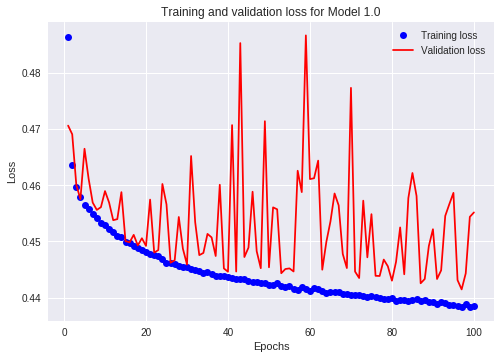

In [25]:
#@title
# MODEL 1.0 PLOT
history_dict = history1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(val_loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss', color='red')
plt.title('Training and validation loss for Model 1.0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 1.0a.png') # image from the folder

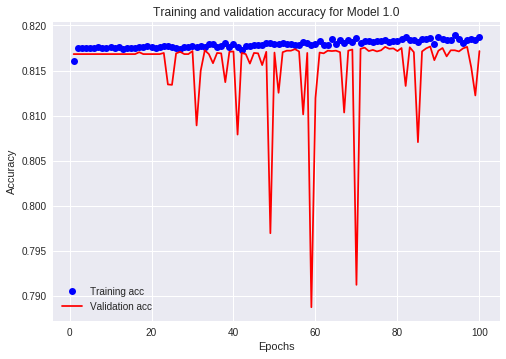

In [27]:
#@title
plt.clf()
acc = history1.history['binary_accuracy']
val_acc = history1.history['val_binary_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy for Model 1.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 1.0b.png') # image from the folder

The model has shown a **strong fluctuating trend**. Despite a slow increasing on the accuracy of the model in relationship with the training data, the model does **not present a reliable situation**. In fact, the noise shown by the plot indicates that the information learnt by the model on the training data do not apply to the new data ( validation data ), generating results which are randomly positive or negative in terms of accuracy and loss. In this perspective, it is possible to conclude that the model suffers overfitting, and with this specific situation the results on the validation data seem widely random.

Moving from this point of view, the first aim is the one to verify if the Ordinal encoding adopted to encode the categorical variables of the dataset , which was justified by the need of simplicity, can represent the main issue and cause of this situation.
As a consequence, data will be re-encoded adopting the so-called **'One-hot encoding' method**.

---

## MODEL 1.1 : Casual parameters with One-Hot encoding

#### **BOTTLENECK INFORMATION**:
It is important to take into consideration that the dataset, having increased the number of variables due to a dummification of two categorical nominal variables, has now increased the size of the inputs, from 11 to 131. In this context it is crucial to be aware about the **risk of creating an information bottleneck**: a layer with a too small dimensional space may be too small to gather all the information obtained from the data, with the consequence of loosing some important information. For this reason care will be taken in the choice of the dimensional space of the hidden layers in order to avoid this risk.

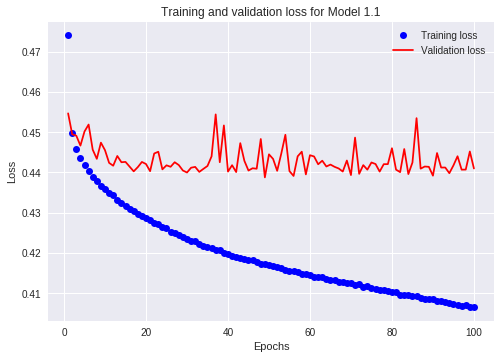

In [31]:
#@title
# MODEL 1.1 PLOT

history_dict = history1_1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(val_loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss', color='red')
plt.title('Training and validation loss for Model 1.1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 1.1a.png') # image from the folder

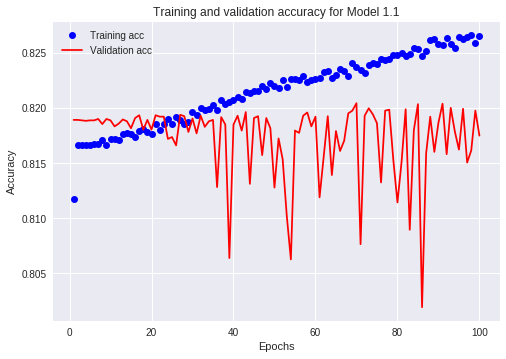

In [32]:
#@title
plt.clf()
acc = history1_1.history['binary_accuracy']
val_acc = history1_1.history['val_binary_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy for Model 1.1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 1.1b.png') # image from the folder

Altought the encoding of some of the categorical variables has been changed, the **model seems to have the same issues**. The loss is sligthly decreased, but the accuracy has done it as well. However, the graph is strongly noisy and unstable, suggesting the presence of overfitting.
As a consequence, before moving on an attempt to increase the accuracy, modification will move in the direction of giving more stability to the model, **diminuishing overfitting** and giving the curve a smoother shape.

---

## REGULARIZATION PROCESS: Facing the Overfitting

### MODEL 2.0: LOWER THE NETWORK
In the attempt to reduce the capacity of the model, there is an attempt to reduce its size, with an attemp to avoid the information bottleneck risk. In this sense, the model will keep two hidden layers, reducing the number of units per layer in order to prevent it to lose its generality and become too specific on the training data.



After having tried to manipulate the following solution, the choice has been made to **two hidden layers with 16 and 4 units per layer**.

* 2 Hidden Layers (64, 4)
* 2 Hidden Layers (32, 4)
* 1 Hidden Layer (64)
* 1 Hidden Layer (32)

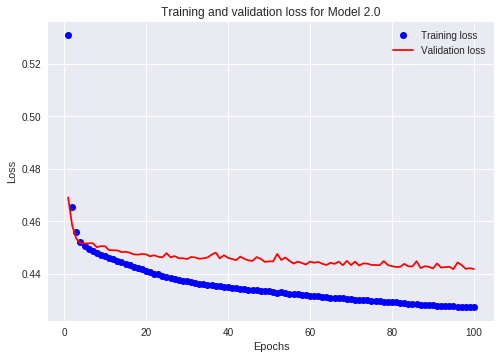

In [34]:
#@title
# MODEL 2.0 PLOT
history_dict = history2.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(val_loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss', color='red')
plt.title('Training and validation loss for Model 2.0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 2.0a.png') # image from the folder

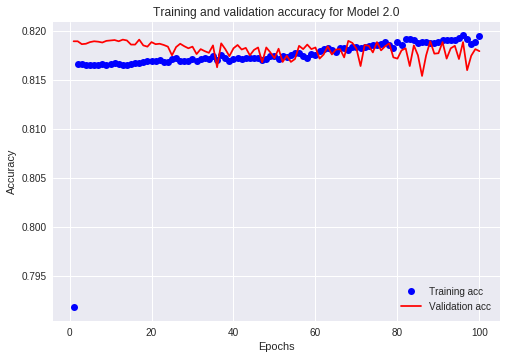

In [36]:
#@title
plt.clf()
acc = history2.history['binary_accuracy']
val_acc = history2.history['val_binary_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy for Model 2.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 2.0b.png') # image from the folder

Having decreased the number of units per layer has given **more stability to the trend of the validation loss**, giving the curve a smoother shape. The accuracy of both the set does not show a remarkable increasing, but a more stable attitude of the curve gives more reliability to the model.

At this point, two techniques can be useful in order to ultimately reduce the noise of the test curves, moving into the direction of increasing the model's performance.


1.  **DROPOUT**


2.  **WEIGHT REGULARIZATION**




### MODEL 3.0: Dropout

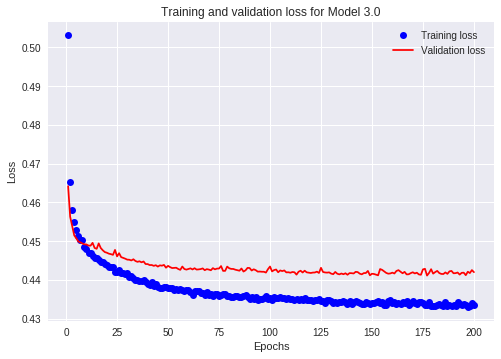

In [38]:
#@title
# MODEL 3.0 PLOT
history_dict = history3.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(val_loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss', color='red')
plt.title('Training and validation loss for Model 3.0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 3.0a.png') # image from the folder

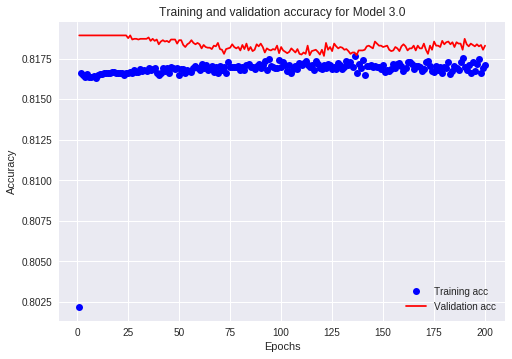

In [39]:
#@title
plt.clf()
acc = history3.history['binary_accuracy']
val_acc = history3.history['val_binary_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy for Model 3.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 3.0b.png') # image from the folder

A **Dropout of 0.2 applied between the two hidden layers** seems to have create a thin distortion on the accuracy, while it has determined a small decrease and stability in the loss function.
From this point of view, the accuracy on the test data seems pretty stable, but it is not possible to determine if it is going to increase or decrease, with an increase in the number of epochs.


---

Since the problem of overfitting seems to be definitely stable, the goal is the one to try to increase the accuracy of the model.

For this purpose, the attempt regards
* Number of Epochs
* Number of Batches
* Learning Rate


Since the attitude of the model is the one to increase, although very slowly, the first attempt is the one to extremise the number of epochs in order to verify if the trend remains stable, after that working on the learning rate can increase the efficiency to get to a improved model.

## MODEL 4.0: Epochs, Batches, Learning Rate

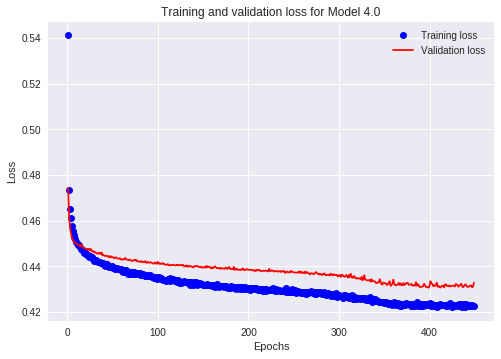

In [60]:
#@title
# MODEL 4.0 PLOT
history_dict = history4.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(val_loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss', color='red')
plt.title('Training and validation loss for Model 4.0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 4.0a.png') # image from the folder

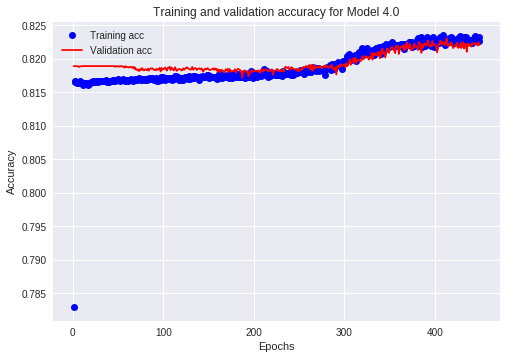

In [61]:
#@title
plt.clf()
acc = history4.history['binary_accuracy']
val_acc = history4.history['val_binary_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy for Model 4.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Image(filename='Model 4.0b.png') # image from the folder

Increasing the number of epochs has shown an attitude towards a model improvement. Although overfitting seems to not be completely solved, the trend seems to be constant. In particular, an attempt to increase the number of epochs to 2000 has shown an improvement between 200 and 400 epochs, with a stability after that.

Moreover, having tried to perform the model with a series of different learning rate (0.1, 0.01, 0.001), the model has shown a better and more stable attitude towards a low level of it. Therefore, a learning rate of 0.001 has been chosen. In this context, the batch size has been increased to 512, while the attempt of using different values, such as  32, 64, 1500, 5000 did not show any improvement, and caused an increase in the level of overfitting moving towards the epochs.

### EARLY STOPPING


In a situation like the one shown in the plot above it could be useful to use the Early stopping method.
However, due to an initial static trend in the accuracy of the model, which tends to increase after roughly 200 epocs, and  a non linear trend, the method attitude can result confusing. In this context, with the parameter patience  set to 40 epochs, the model has been stopped after 449 epochs, roughly confirming the empiric observation. 
 

In [0]:
from keras.models import load_model

model.save('lasvegas_model.h5')


# my_model = load_model('lasvegas_model.h5') # Code to load the module obtained

---

# <font color='EC2C04'> EVALUATION </font>

The analysis has been conducted with the attempt to build a binary classification model which could be able to predict the departure delay of a flight from the International airport of Las Vegas (USA).

For this purpose, it has been initially verified the lowest acceptable percentage of a predictive model, below which the model would not have resulted in a successful model. To make this possible, the Baseline model has been calculated .

Secondly, the model has been set with reasonable parameters in order to build a starting point model, which could indicate the direction to adopt for it to be improved. In this context, the first goal has regarded the necessity to modify the method of encoding with which the categorical variable had been organized ( from a 'Ordinal Encoding' to 'One-hot encoding'), followed by a strong necessity to reduce the overfitting of the model, which has been observed since the beginning with a very noisy validation loss curve and accuracy curve. The regularization process, which is the technique adopted to contrast the overfitting, has firstly moved into the direction of lowering the network, maintaining two hidden layer but changing the number of units per layer from 64 and 32 to 16 and 4. In addition, the dropout technique has been introduced with a parameter of 0.2 set between the two hidden layers. 

In conclusion, when the issue related to the overfitting has been limited, the model has been modified in the batch size, by increasing it 512 and the learning rate has been set to 0.001 after a series of experiments in which it has been modified between a range of 0.1 and 0.001 to verify its influence on the model. Moreover, an increase in the number of epochs has allowed to observe that the optimal number of epochs could be set around 400.

The Early stopping technique has confirmed the hypotesis, stopping the process of optimisation of the model after 449 epochs, with a patience parameter set to 40 in order to contrast the initial stagnancy of the accuracy curve of the model.


**CONCLUSION**

The process of predicting delays in this analysis has probably suffered the great amount of categorical variables, which have been converted into categories through the one-hot encoding process. In this context, the number of binary variables has widely increased and this situation can have lead to a sort of weakness on the model. However, it important to observe how the model has proven to be stable and its accuracy has at the end set to 82.18%.
